# Preparing and testing functions

In [1]:
import pandas as pd
import numpy as np

class DataCleaner:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        return pd.read_csv(self.file_path)

    def clean_data(self, df):
        # Drop columns with a large number of missing values
        df = df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

        # Drop rows with specific missing values
        df = df[df['diag_1'] != '?']
        df = df[df['diag_2'] != '?']
        df = df[df['diag_3'] != '?']
        df = df[df['race'] != '?']
        df = df[df['gender'] != 'Unknown/Invalid']
        df = df[df['discharge_disposition_id'] != 11]

        # Replace values in A1Cresult and max_glu_serum
        a1c_replacements = {'>7': 1, '>8': 1, 'Norm': 0}
        df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)

        max_glu_serum_replacements = {'>200': 1, '>300': 1, 'Norm': 0}
        df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)

        # Drop columns with identical values in all rows
        columns_to_drop = ['examide', 'citoglipton', 'metformin-rosiglitazone']
        df = df.drop(columns_to_drop, axis=1)

        return df

    def feature_engineering(self, df):
        # Comorbidity count
        comorbidity_ranges = {
            'infectious_parasitic_diseases': (1, 139),
            'neoplasms': (140, 239),
            'endocrine_nutritional_metabolic_immunity_disorders': (240, 279),
            'blood_diseases': (280, 289),
            'mental_disorders': (290, 319),
            'nervous_system_diseases': (320, 389),
            'circulatory_system_diseases': (390, 459),
            'respiratory_system_diseases': (460, 519),
            'digestive_system_diseases': (520, 579),
            'genitourinary_system_diseases': (580, 629),
            'pregnancy_childbirth_complications': (630, 679),
            'skin_diseases': (680, 709),
            'musculoskeletal_system_diseases': (710, 739),
            'congenital_anomalies': (740, 759),
            'perinatal_conditions': (760, 779),
            'symptoms_signs_ill_defined_conditions': (780, 799),
            'injury_poisoning': (800, 999),
            'external_causes_supplemental': ('E', 'V')
        }

        def is_comorbidity(code, comorbidity_ranges):
            try:
                code_int = int(code)
                for comorbidity, (start, end) in comorbidity_ranges.items():
                    if start != 'E' and start != 'V' and start <= code_int <= end:
                        return True
            except ValueError:
                if any(code.startswith(prefix) for prefix in ['E', 'V']):
                    return True
            return False

        def count_comorbidities(row, comorbidity_ranges):
            count = 0
            if is_comorbidity(row['diag_1'], comorbidity_ranges):
                count += 1
            if is_comorbidity(row['diag_2'], comorbidity_ranges):
                count += 1
            if is_comorbidity(row['diag_3'], comorbidity_ranges):
                count += 1
            return count

        df['comorbidity_count'] = df.apply(lambda row: count_comorbidities(row, comorbidity_ranges), axis=1)

        # Visit history summary
        df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

        # Recode columns
        admission_type_mapping = {2: 1, 7: 1, 6: 5, 8: 5}
        discharge_disposition_mapping = {
            6: 1, 8: 1, 9: 1, 13: 1, 3: 2, 4: 2, 5: 2, 14: 2, 22: 2, 23: 2, 24: 2, 12: 10,
            15: 10, 16: 10, 17: 10, 25: 18, 26: 18
        }
        admission_source_mapping = {
            2: 1, 3: 1, 5: 4, 6: 4, 10: 4, 22: 4, 25: 4, 15: 9, 17: 9, 20: 9, 21: 9, 13: 11, 14: 11
        }

        df['admission_type_id'] = df['admission_type_id'].replace(admission_type_mapping)
        df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(discharge_disposition_mapping)
        df['admission_source_id'] = df['admission_source_id'].replace(admission_source_mapping)

        # Long stay feature
        df['long_stay'] = (df['time_in_hospital'] > 7).astype(int)

        # Medication columns
        medication_cols = df.loc[:, 'metformin':'metformin-pioglitazone'].columns
        for col in medication_cols:
            colname = str(col) + 'temp'
            df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
        df['numchange'] = df[[str(col) + 'temp' for col in medication_cols]].sum(axis=1)
        df.drop(columns=[str(col) + 'temp' for col in medication_cols], inplace=True)

        for col in medication_cols:
            df[col] = df[col].replace('No', 0)
            df[col] = df[col].replace('Steady', 1)
            df[col] = df[col].replace('Up', 1)
            df[col] = df[col].replace('Down', 1)

        # Number of medications used
        df['nummed'] = 0
        for col in medication_cols:
            df['nummed'] = df['nummed'] + df[col]


        # Calculate age_midpoint from age column
        age_mapping = {
            '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
            '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
        }
        df['age'] = df['age'].replace(age_mapping)

        # Convert change to numeric
        df['change'] = df['change'].replace('Ch', 1)
        df['change'] = df['change'].replace('No', 0)

        # Interaction terms
        interaction_terms = [
            ('num_medications', 'time_in_hospital'),
            ('num_medications', 'num_procedures'),
            ('time_in_hospital', 'num_lab_procedures'),
            ('num_medications', 'num_lab_procedures'),
            ('num_medications', 'number_diagnoses'),
            ('age', 'number_diagnoses'),
            ('age', 'comorbidity_count'),
            ('change', 'num_medications'),
            ('number_diagnoses', 'time_in_hospital'),
            ('num_medications', 'numchange')
        ]

        for inter in interaction_terms:
            name = inter[0] + '|' + inter[1]
            df[name] = df[inter[0]] * df[inter[1]]

        # Categorizing diagnosis
        for col in ['diag_1', 'diag_2', 'diag_3']:
            df[f'level1_{col}'] = df[col]

        for col in ['level1_diag_1', 'level1_diag_2', 'level1_diag_3']:
            df[col] = df[col].replace({r'^V.*': 0, r'^E.*': 0}, regex=True)

        df.replace('?', -1, inplace=True)

        for col in ['level1_diag_1', 'level1_diag_2', 'level1_diag_3']:
            df[col] = df[col].astype(float)

        def classify_diag_level1(value):
            if value >= 390 and value < 460 or np.floor(value) == 785:
                return 1
            elif value >= 460 and value < 520 or np.floor(value) == 786:
                return 2
            elif value >= 520 and value < 580 or np.floor(value) == 787:
                return 3
            elif np.floor(value) == 250:
                return 4
            elif value >= 800 and value < 1000:
                return 5
            elif value >= 710 and value < 740:
                return 6
            elif value >= 580 and value < 630 or np.floor(value) == 788:
                return 7
            elif value >= 140 and value < 240:
                return 8
            else:
                return 0

        df['level1_diag_1'] = df['level1_diag_1'].apply(classify_diag_level1)
        df['level1_diag_2'] = df['level1_diag_2'].apply(classify_diag_level1)
        df['level1_diag_3'] = df['level1_diag_3'].apply(classify_diag_level1)

        # Drop original columns that have been encoded or aggregated
        df.drop(['number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3'],
          axis=1, inplace=True)

        # Change column data types
        cols = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'A1Cresult', 'max_glu_serum']
        df[cols] = df[cols].astype('object')

        # Encoding the target variable
        readmitted_mapping = {'>30': 0, '<30': 1, 'NO': 0}
        df['readmitted'] = df['readmitted'].replace(readmitted_mapping)

        # Dropping Duplicates
        df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
        df = df.drop(['encounter_id', 'patient_nbr'], axis=1)

        return df


In [2]:
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)
processed_data = data_cleaner.feature_engineering(cleaned_data)


/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_18335/3045994153.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_18335/3045994153.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_18335/3045994153.py:114: FutureWarning: Downcasting behav

In [2]:
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
#from data import DataCleaner

# Load the data and preprocess
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)
processed_data = data_cleaner.feature_engineering(cleaned_data)

# Numeric preprocessing pipeline (excluding 'readmitted')
numeric_columns = [col for col in processed_data.select_dtypes(include=['number']).columns if col != 'readmitted']
num_preproc = Pipeline([
    ('scaler', StandardScaler())
])


# Categorical preprocessing pipeline (excluding 'age')
categorical_columns = processed_data.select_dtypes(include=['object']).columns
cat_preproc = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, drop="if_binary", handle_unknown='ignore'))
])

# Combined preprocessing pipeline
preproc = ColumnTransformer([
    ('num_transf', num_preproc, numeric_columns),
    ('cat_transf', cat_preproc, categorical_columns)
], verbose_feature_names_out=False)


# Create a pipeline with SMOTE and preprocessing
pipe_preproc = ImbPipeline([
    ('preprocessor', preproc),
])
pipe_preproc


/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:114: FutureWarning: Downcasting behav

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transf',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_diagnoses',
                                                   'metformin', 'repaglinide',
                                                   'nateglinide',
                                                   'chlorpropamide',
                                                   'glimepiride',
                                                   'acetohexamide', 'glipizide',
                                                   'glyburide', 'tolbutamide',...
                                                   'comorbidity_count',
                                                   'total_visits', 'long_stay', ...]),
                                                 ('cat_transf',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'max_glu_serum', 'A1Cresult', 'diabetesMed'],
      dtype='object'))],
                                   verbose_feature_names_out=False))])

In [3]:
# Load the data and preprocess
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)
processed_data = data_cleaner.feature_engineering(cleaned_data)

X_train = processed_data.drop(columns=['readmitted'])
y_train = processed_data[['readmitted']]

X_train.shape, y_train.shape

/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:114: FutureWarning: Downcasting behav

((67580, 53), (67580, 1))

## Model

In [4]:
# Load the data and preprocess
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)
processed_data = data_cleaner.feature_engineering(cleaned_data)

# Apply the preprocessing pipeline to data
# Separate features and target
X = processed_data.drop('readmitted', axis=1)
y = processed_data['readmitted']

/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['A1Cresult'] = df['A1Cresult'].replace(a1c_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['max_glu_serum'] = df['max_glu_serum'].replace(max_glu_serum_replacements).fillna(-99)
/var/folders/nw/jh8cgbmd7zvcd0mxm5ks23pc0000gn/T/ipykernel_81212/3045994153.py:114: FutureWarning: Downcasting behav

In [5]:
from sklearn.model_selection import train_test_split
# Split the data into training + validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Further split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True)  # 0.25 * 0.8 = 0.2

In [6]:
# Fit and transform the training data with preprocessing pipeline
X_train_preprocessed = pipe_preproc.fit_transform(X_train)
X_val_preprocessed = pipe_preproc.transform(X_val)
X_test_preprocessed = pipe_preproc.transform(X_test)

In [7]:
# Save the preprocessing pipeline as a pickle file
with open('../preprocessor/preprocessing_pipeline.pkl', 'wb') as file:
    pickle.dump(pipe_preproc, file)

In [8]:
# Apply SMOTE to the preprocessed training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

In [9]:
from collections import Counter

print(f"Original training set distribution: {Counter(y_train)}")
print(f"Resampled training set distribution: {Counter(y_train_smote)}")


Original training set distribution: Counter({0: 36877, 1: 3671})
Resampled training set distribution: Counter({0: 36877, 1: 36877})


In [10]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators=10, max_depth=25, criterion="gini", min_samples_split=10, class_weight={0: 1, 1: 10})

rm.fit(X_train_smote, y_train_smote)
best_model = rm

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_val_pred_gb = rm.predict(X_val_preprocessed)
print("Random Forest Validation Performance")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_gb):.4f}")
print(f"Validation Precision: {precision_score(y_val, y_val_pred_gb):.4f}")
print(f"Validation Recall: {recall_score(y_val, y_val_pred_gb):.4f}")
gb_score = accuracy_score(y_val, y_val_pred_gb)

Random Forest Validation Performance
Validation Accuracy: 0.8151
Validation Precision: 0.1282
Validation Recall: 0.1832


In [13]:
y_test_pred = best_model.predict(X_test_preprocessed)
print("Best Model Test Performance")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")

Best Model Test Performance
Test Accuracy: 0.8148
Test Precision: 0.1283
Test Recall: 0.1742


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[10796  1474]
 [ 1029   217]]


In [15]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('preprocessor', pipe_preproc),  # Use pipe_preproc without parentheses
    ('Random Forest', best_model)
])

# Check the pipeline
pipe


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num_transf',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'time_in_hospital',
                                                                    'num_lab_procedures',
                                                                    'num_procedures',
                                                                    'num_medications',
                                                                    'number_diagnoses',
                                                                    'metformin',
                                                                    'repaglinide',
                                                                    'nateglinide',
                                                                    'chlorpropamide',
                                                                    'glimepiride',
                                                                    'acetohexamide',
                                                                    'glipi...
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   Index(['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'max_glu_serum', 'A1Cresult', 'diabetesMed'],
      dtype='object'))],
                                                    verbose_feature_names_out=False))])),
                ('Random Forest',
                 RandomForestClassifier(class_weight={0: 1, 1: 10},
                                        max_depth=25, min_samples_split=10,
                                        n_estimators=10))])

In [16]:
import pickle
with open('../models/best_model.pkl', 'wb') as file:
    pickle.dump(pipe, file)

In [17]:
# Assuming X_train is a Pandas DataFrame and X_train_preprocessed is a NumPy array after preprocessing
# Store the column names before preprocessing
original_columns = X_train.columns

# Fit and transform the training data with preprocessing pipeline
X_train_preprocessed = pipe_preproc.fit_transform(X_train)

# Assuming gb is already trained and X_train_preprocessed contains your training data after preprocessing
feature_importances = gb.feature_importances_

# Pair feature importances with original column names
feature_importance_dict = dict(zip(original_columns, feature_importances))

# Sort features by importance (descending order)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Select top n features (e.g., top 10 features)
top_features = [feat for feat, importance in sorted_features[:10]]  # Adjust the number as per your requirement

print("Top 15 features:")
print(top_features)


Top 15 features:
['level1_diag_1', 'num_medications|number_diagnoses', 'insulin', 'race', 'change|num_medications', 'num_medications|num_lab_procedures', 'time_in_hospital|num_lab_procedures', 'level1_diag_2', 'gender', 'admission_type_id']


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# Define a function to test various feature combinations
def find_combinations_for_yes(model, preprocessor):
    # Define possible values for key features
    feature_values = {
        'age': [25, 45, 65, 75],
        'gender': ['Male', 'Female'],
        'race': ['AfricanAmerican', 'Caucasian'],
        'level1_diag_1': [1, 0, 8],
        'insulin': [0, 1],
        'change': [0, 1],
        'num_lab_procedures': [40, 50, 60],
        'num_medications': [11, 12, 15],
        'number_diagnoses': [5],
        'admission_type_id': ['1'],
        'time_in_hospital': [2, 7, 14]
    }

    # Fixed values for other features
    fixed_values = {
        'discharge_disposition_id': "1",
        'admission_source_id': "7",
        'num_procedures': 1,
        'max_glu_serum': "-99.0",
        'A1Cresult': "-99.0",
        'metformin': 0,
        'repaglinide': 0,
        'nateglinide': 0,
        'chlorpropamide': 0,
        'glimepiride': 0,
        'acetohexamide': 0,
        'glipizide': 0,
        'glyburide': 0,
        'tolbutamide': 0,
        'pioglitazone': 0,
        'rosiglitazone': 0,
        'acarbose': 0,
        'miglitol': 0,
        'troglitazone': 0,
        'tolazamide': 0,
        'insulin': 1,
        'glyburide-metformin': 0,
        'glipizide-metformin': 0,
        'glimepiride-pioglitazone': 0,
        'metformin-pioglitazone': 0,
        'diabetesMed': 'Yes',
        'comorbidity_count': 3,
        'total_visits': 0,
        'long_stay': 0,
        'numchange': 1,
        'nummed': 1,
        'num_medications|time_in_hospital': 54,
        'num_medications|num_procedures': 0,
        'time_in_hospital|num_lab_procedures': 177,
        'num_medications|num_lab_procedures': 1062,
        'num_medications|number_diagnoses': 162,
        'age|number_diagnoses': 135,
        'age|comorbidity_count': 30,
        'change|num_medications': 18,
        'number_diagnoses|time_in_hospital': 27,
        'num_medications|numchange': 18,
        'level1_diag_2': 1,
        'level1_diag_3': 1
    }

    results = []

    # Generate all combinations of key feature values
    for age in feature_values['age']:
        for gender in feature_values['gender']:
            for race in feature_values['race']:
                for level1_diag_1 in feature_values['level1_diag_1']:
                    for insulin in feature_values['insulin']:
                        for change in feature_values['change']:
                            for num_lab_procedures in feature_values['num_lab_procedures']:
                                for num_medications in feature_values['num_medications']:
                                    for number_diagnoses in feature_values['number_diagnoses']:
                                        for admission_type_id in feature_values['admission_type_id']:
                                            for time_in_hospital in feature_values['time_in_hospital']:
                                                # Create a DataFrame with the current combination and fixed values
                                                test_df = pd.DataFrame({
                                                    'age': [age],
                                                    'gender': [gender],
                                                    'race': [race],
                                                    'level1_diag_1': [level1_diag_1],
                                                    'insulin': [insulin],
                                                    'change': [change],
                                                    'num_lab_procedures': [num_lab_procedures],
                                                    'num_medications': [num_medications],
                                                    'number_diagnoses': [number_diagnoses],
                                                    'admission_type_id': [admission_type_id],
                                                    'time_in_hospital': [time_in_hospital],
                                                    # Include fixed values for the other features
                                                    **{k: [v] for k, v in fixed_values.items()}
                                                })

                                                # Preprocess the data
                                                preprocessed_data = preprocessor.transform(test_df)

                                                # Make prediction
                                                prediction = model.predict(preprocessed_data)[0]

                                                if prediction == 1:
                                                    results.append({
                                                        'age': age,
                                                        'gender': gender,
                                                        'race': race,
                                                        'level1_diag_1': level1_diag_1,
                                                        'insulin': insulin,
                                                        'change': change,
                                                        'num_lab_procedures': num_lab_procedures,
                                                        'num_medications': num_medications,
                                                        'number_diagnoses': number_diagnoses,
                                                        'admission_type_id': admission_type_id,
                                                        'time_in_hospital': time_in_hospital
                                                    })

    return results

# Example usage
# Load your model and preprocessor
# Assuming 'best_model' is your trained model and 'pipe_preproc' is your preprocessing pipeline
combinations_for_yes = find_combinations_for_yes(best_model, pipe_preproc)

print("Combinations that lead to a 'YES' prediction:")
for combo in combinations_for_yes:
    print(combo)

/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocess

Combinations that lead to a 'YES' prediction:
{'age': 25, 'gender': 'Male', 'race': 'Caucasian', 'level1_diag_1': 1, 'insulin': 0, 'change': 0, 'num_lab_procedures': 50, 'num_medications': 11, 'number_diagnoses': 5, 'admission_type_id': '1', 'time_in_hospital': 7}
{'age': 25, 'gender': 'Male', 'race': 'Caucasian', 'level1_diag_1': 1, 'insulin': 0, 'change': 0, 'num_lab_procedures': 50, 'num_medications': 11, 'number_diagnoses': 5, 'admission_type_id': '1', 'time_in_hospital': 14}
{'age': 25, 'gender': 'Male', 'race': 'Caucasian', 'level1_diag_1': 1, 'insulin': 0, 'change': 0, 'num_lab_procedures': 50, 'num_medications': 12, 'number_diagnoses': 5, 'admission_type_id': '1', 'time_in_hospital': 7}
{'age': 25, 'gender': 'Male', 'race': 'Caucasian', 'level1_diag_1': 1, 'insulin': 0, 'change': 0, 'num_lab_procedures': 50, 'num_medications': 12, 'number_diagnoses': 5, 'admission_type_id': '1', 'time_in_hospital': 14}
{'age': 25, 'gender': 'Male', 'race': 'Caucasian', 'level1_diag_1': 1, 'insu

/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocess

In [19]:
combinations_for_yes[1]

{'age': 25,
 'gender': 'Male',
 'race': 'Caucasian',
 'level1_diag_1': 1,
 'insulin': 0,
 'change': 0,
 'num_lab_procedures': 50,
 'num_medications': 11,
 'number_diagnoses': 5,
 'admission_type_id': '1',
 'time_in_hospital': 14}

In [24]:
input_data = {
    'age': 25,
    'gender': 'Male',
    'race': 'Caucasian',
    'level1_diag_1': 1,
    'insulin': 0,
    'change': 0,
    'num_lab_procedures': 50,
    'num_medications': 11,
    'number_diagnoses': 5,
    'admission_type_id': '1',
    'time_in_hospital': 14,
    'discharge_disposition_id': "1",
    'admission_source_id': "7",
    'num_procedures': 1,
    'max_glu_serum': "-99.0",
    'A1Cresult': "-99.0",
    'metformin': 0,
    'repaglinide': 0,
    'nateglinide': 0,
    'chlorpropamide': 0,
    'glimepiride': 0,
    'acetohexamide': 0,
    'glipizide': 0,
    'glyburide': 0,
    'tolbutamide': 0,
    'pioglitazone': 0,
    'rosiglitazone': 0,
    'acarbose': 0,
    'miglitol': 0,
    'troglitazone': 0,
    'tolazamide': 0,
    'insulin': 1,
    'glyburide-metformin': 0,
    'glipizide-metformin': 0,
    'glimepiride-pioglitazone': 0,
    'metformin-pioglitazone': 0,
    'diabetesMed': 'Yes',
    'comorbidity_count': 3,
    'total_visits': 0,
    'long_stay': 0,
    'numchange': 1,
    'nummed': 1,
    'num_medications|time_in_hospital': 54,
    'num_medications|num_procedures': 0,
    'time_in_hospital|num_lab_procedures': 177,
    'num_medications|num_lab_procedures': 1062,
    'num_medications|number_diagnoses': 162,
    'age|number_diagnoses': 135,
    'age|comorbidity_count': 30,
    'change|num_medications': 18,
    'number_diagnoses|time_in_hospital': 27,
    'num_medications|numchange': 18,
    'level1_diag_2': 1,
    'level1_diag_3': 1
}

# Create a DataFrame
input_df = pd.DataFrame([input_data])

In [25]:
pipe.predict(input_df)

/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([1])

In [26]:
input_transform = pipe_preproc.transform(input_df)
best_model.predict(input_transform)

/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([1])

In [27]:
# Load the model back from the file
with open('../models/best_model.pkl', 'rb') as file:
    testmodel = pickle.load(file)

# Make prediction
prediction = testmodel.predict(input_df)

print(prediction)


[1]


/Users/virginiawenger/.pyenv/versions/3.10.6/envs/hospital_readmission/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
data_cleaner = DataCleaner('../raw_data/diabetic_data.csv')
data = data_cleaner.load_data()
cleaned_data = data_cleaner.clean_data(data)

In [31]:
data.diag_1.value_counts()

diag_1
428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
373       1
314       1
684       1
217       1
V51       1
Name: count, Length: 717, dtype: int64

Text(0, 0, '51%')

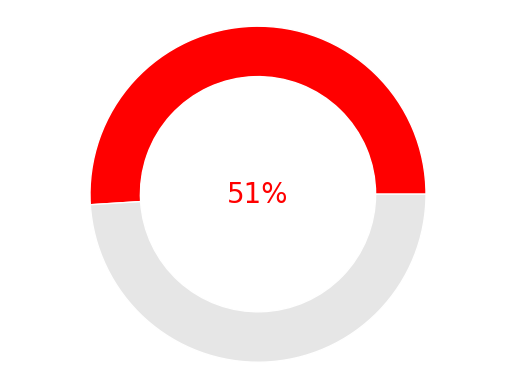

In [11]:
import matplotlib.pyplot as plt
probability = 0.51
fig, ax = plt.subplots()
size = 0.3

# Create data for the donut chart
values = [probability, 1 - probability]

color = 'red' if probability >0.5 else 'green'
colors = [color, '#e6e6e6']

ax.pie(values, colors=colors, radius=1, wedgeprops=dict(width=size, edgecolor='w'))

# Add a circle in the center to create the donut shape
centre_circle = plt.Circle((0,0), 1-size, color='white', fc='white', linewidth=0)
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Add the percentage text in the center of the donut chart
plt.text(0, 0, f'{probability * 100:.0f}%', ha='center', va='center', fontsize=20, color=color)